In [1]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import transform
from skimage import registration

from scipy import ndimage
from scipy import signal
from scipy import stats
from scipy import ndimage as ndi

## Setup

#### Func.

In [2]:
def cell_masking(input_img, soma_mask=True, soma_th=0.5, soma_ext=100, proc_ext=10):
    # soma masking
    if soma_mask:
        soma_region = np.copy(input_img)
        soma_region = soma_region > soma_region.max() * soma_th
        soma_region = morphology.opening(soma_region, footprint=morphology.disk(5))
        # soma_region = morphology.dilation(soma_region, footprint=morphology.disk(10))
        soma_dist = ndimage.distance_transform_edt(~soma_region, return_indices=False)
        soma_mask = soma_dist < soma_ext
        input_img = ma.masked_where(soma_mask, input_img)

        th = filters.threshold_otsu(input_img.compressed())
    else:
        th = filters.threshold_otsu(input_img)

    # processes masking
    proc_mask = input_img > th
    proc_mask = morphology.closing(proc_mask, footprint=morphology.disk(5))
    proc_dist = ndimage.distance_transform_edt(~proc_mask, return_indices=False)
    proc_mask_fin = proc_dist < proc_ext
    proc_mask_fin[soma_mask] = 0

    return proc_mask_fin


def Fc_calc(dd_img, da_img, aa_img, a, b, c, d):
    Fc_img = []
    for frame_num in range(dd_img.shape[0]):
        DD_frame = dd_img[frame_num]
        DA_frame = da_img[frame_num]
        AA_frame = aa_img[frame_num]

        Fc_frame = DA_frame - a*(AA_frame - c*DD_frame) - d*(DD_frame - b*AA_frame)
        Fc_img.append(Fc_frame)

    return np.asarray(Fc_img)


def E_app_calc(fc_img, dd_img, G, mask):
    R_img = []
    E_app_img = []
    for frame_num in range(fc_img.shape[0]):
        Fc_frame = fc_img[frame_num]
        DD_frame = dd_img[frame_num]

        R_frame = Fc_frame / DD_frame
        R_frame = R_frame
        E_app_frame = R_frame / (R_frame + G)

        E_app_frame[E_app_frame < 0] = 0
        E_app_frame[~mask] = 0

        R_img.append(R_frame)
        E_app_img.append(E_app_frame)

    return np.asarray(R_img), np.asarray(E_app_img)


def E_cor_calc():
    pass

#### Coef.

In [3]:
a = 0.144
b = 0.1292
c = 0.2458
d = 0.8506
abcd = [a, b, c, d]

G = 15.925

## Uploading & preprocessing

In [4]:
input_path = 'data/input/11.tif'

img_raw = io.imread(input_path)

DD_img = img_raw[:,:,:,0]  # CFP-435  DD
DA_img = img_raw[:,:,:,1]  # YFP-435  DA
AD_img = img_raw[:,:,:,2]  # CFP-505  AD
AA_img = img_raw[:,:,:,3]  # YFP-505  AA

DD_mean_img = np.mean(DD_img, axis=0)
DA_mean_img = np.mean(DA_img, axis=0)
AD_mean_img = np.mean(AD_img, axis=0)
AA_mean_img = np.mean(AA_img, axis=0)

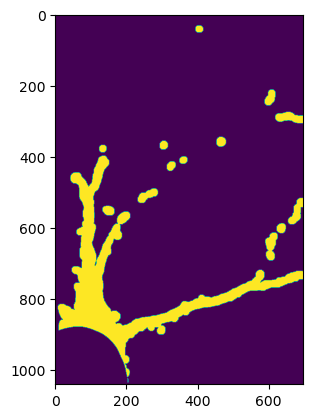

In [5]:
mask = cell_masking(AA_mean_img, soma_mask=True)
plt.imshow(mask)

In [6]:
Fc = Fc_calc(dd_img=DD_img,
             da_img=DA_img,
             aa_img=AA_img,
             a=a, b=b, c=c, d=d)

R, E_app = E_app_calc(fc_img=Fc, dd_img=DD_img, G=G, mask=mask)

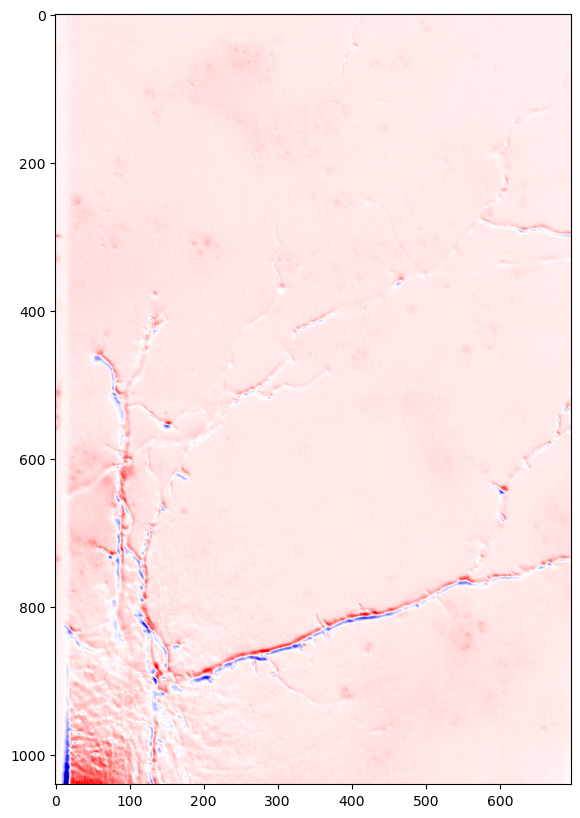

In [7]:
Fc_lim = np.max(np.abs(Fc))

plt.figure(figsize=(10,10))
plt.imshow(Fc[20], cmap='seismic', vmin=-Fc_lim, vmax=Fc_lim)

(-0.5, 695.5, 1039.5, -0.5)

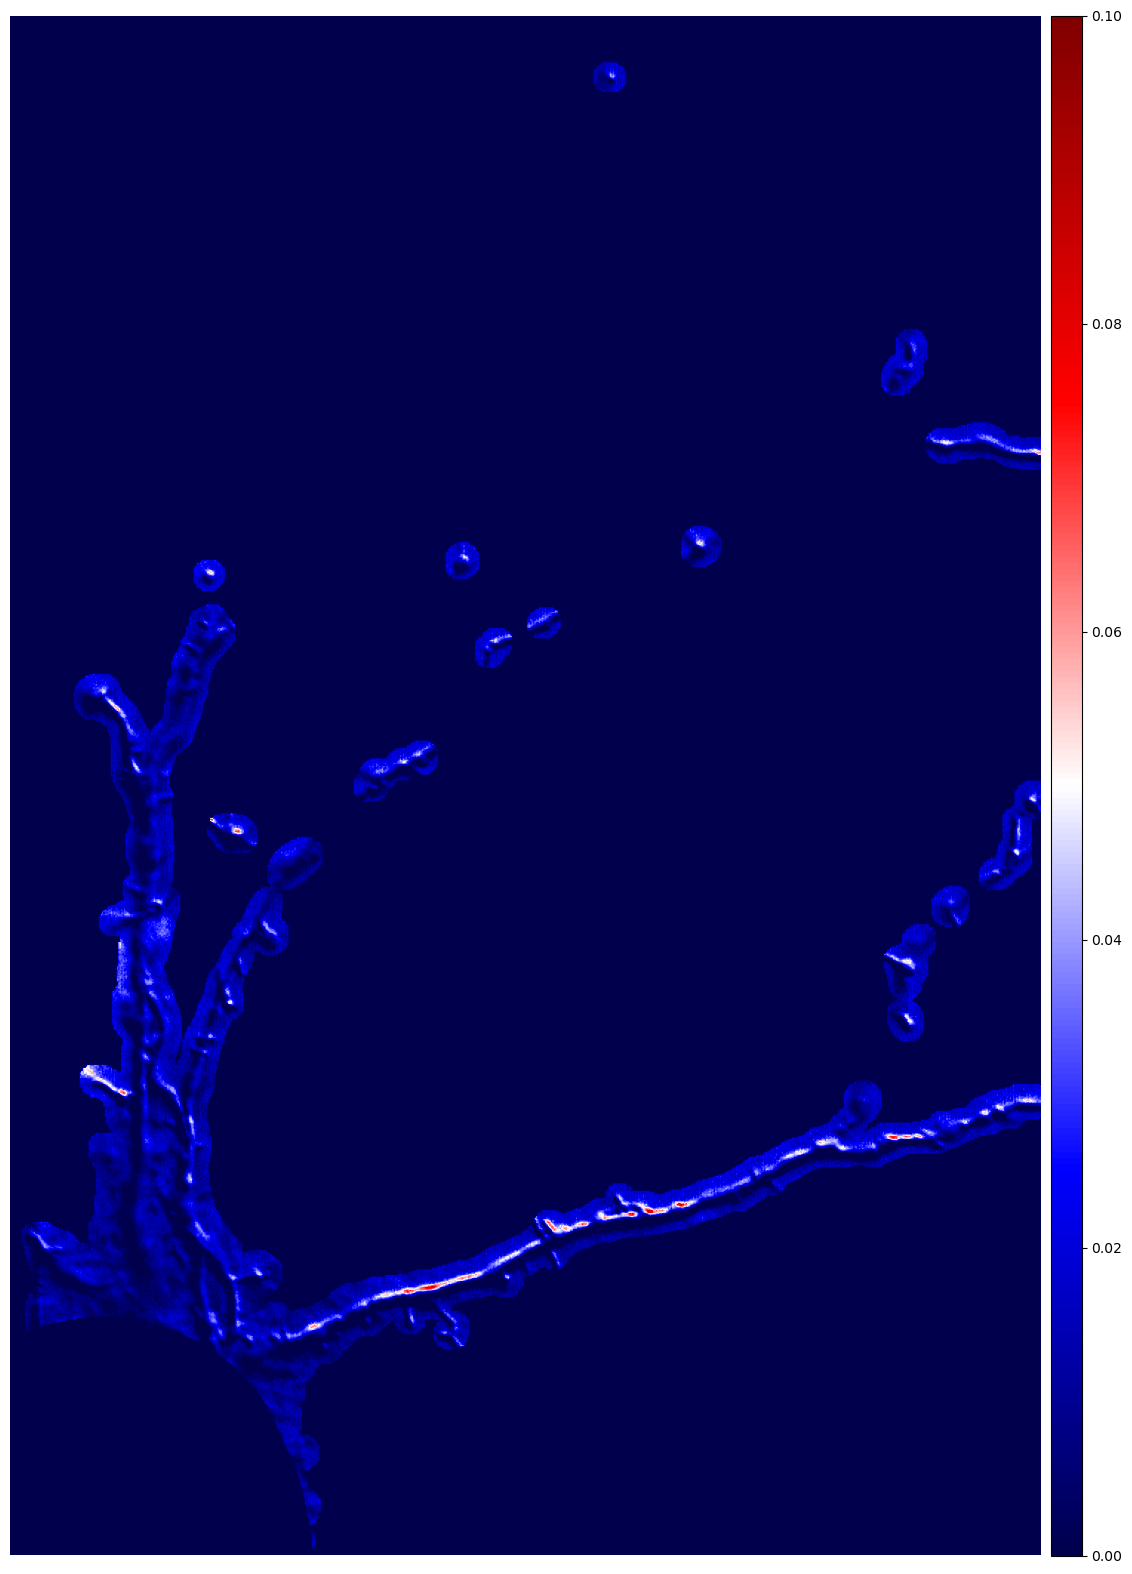

In [9]:
E_app_lim = np.max(np.abs(E_app))

frame_num = 10

plt.figure(figsize=(20,20))

ax0 = plt.subplot()
img0 = ax0.imshow(E_app[frame_num], cmap='seismic', vmin=0, vmax=0.1)
div0 = make_axes_locatable(ax0)
cax0 = div0.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img0, cax=cax0)
ax0.axis('off')